# Part 4: Sentiment of the artists and communities

**The questions below are based on Lecture 8**

In [40]:
# SETUP

# Import necessary libraries
import os
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk import FreqDist
import networkx as nx
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Prepare NLTK resources 
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

True

## 1. Calculate the sentiment of the band/artist pages

The LabMT word list (Language Assessment by Mechanical Turk) is a sentiment lexicon where thousands of English words were given a fixed happiness score (1 to 9) by workers in the Mechanical Turk platform. A score of 1 represents extremely negative sentiment, 5 corresponds to neutral, and 9 indicates extremely positive sentiment and each word’s final score was obtained by averaging around 50 individual ratings. The word list was downloaded and saved locally as labmt_wordlist.txt and a dictionary was created for word-hapinness-score lookup.

In [41]:
# Skip the header lines and load the word list into a DataFrame
with open("labmt_wordlist.txt", "r") as f:
    word_list = f.readlines()
data_str = "".join(word_list[3:])
labmt_df = pd.read_csv(StringIO(data_str), sep="\t")
display(labmt_df.head())

# Create a dictionary for word happiness lookup
labmt_dict = dict(zip(labmt_df["word"], labmt_df["happiness_average"]))
labmt_dict["happy"] 

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


8.3

Then, we create a function that takes as input a list of tokens, fetches each of their happiness score (if found in the list), and calculates the average sentiment of the total text. As recommended, we use the **FreqDist** because it efficiently counts the frequency of each unique token, allowing us to compute weighted sentiment scores without repeatedly scanning the entire token list.

In [42]:
def calculate_sentiment(tokens, labmt_dict):
    """Calculate sentiment score for a list of tokens using labmt_df as reference."""
    
    fd = FreqDist(tokens)  
    sentiment_score = 0
    matched_tokens = 0

    for token, freq in fd.items():
        token_score = labmt_dict.get(token)
        if token_score is not None:  
            sentiment_score += token_score * freq
            matched_tokens += freq

    total_tokens = sum(fd.values())
    if matched_tokens == 0:
        print("No words matched in sentiment dictionary.")
        return None

    #percent_found = (matched_tokens / total_tokens) * 100
    #print(f"{percent_found:.2f}% of words were found in the sentiment dictionary.")

    average_sentiment = sentiment_score / matched_tokens
    return average_sentiment

# Test the function
test_tokens = ["happy", "joyful", "excited"]
print(calculate_sentiment(test_tokens, labmt_dict)) 

7.960000000000001


The stored network graph "new_rock_artists.graphml" is loaded, we convert it to an undirected graph, iterate over all its nodes to calculate the sentiment for each artist's Wikipedia page and add that sentiment score as a node attribute.

In [43]:
# Load graph and convert to undirected
G = nx.read_graphml("new_network/new_rock_artists.graphml")
G_und = G.to_undirected(reciprocal=False, as_view=False)

In [44]:
# Load the WordNet lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Iterate over nodes to load artist texts and calculate sentiment
print("Loading artist texts and calculating sentiment...")

for node in G_und.nodes():
    # open artist file
    folder_path="new_network/artist_texts"
    filename = node + ".txt" 
    file_path = os.path.join(folder_path, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        node_text = f.read()

    wiki_terms = {
        'cite', 'ref', '/ref', 'category', 'infobox', 'stub', 'short', 'description', 'template',
        'file', 'image', 'external', 'links', 'references', 'see', 'also', 'edit', 'wikidata',
        'article', 'band', 'album', 'name', 'page', 'list', 'track', 'single', 'released', 'chart',
        'music', 'label', 'record', 'records', 'artist', 'group', 'song', 'songs', 'year', 'years',
        'date', 'title', 'awards', 'award', 'official', 'website', 'link', 'bio', 'history', 'http'}
    
    # Tokenize into words
    tokens = nltk.word_tokenize(node_text)
    
    # Remove punctuation and make lowercase
    tokens = [t.lower() for t in tokens if t.isalpha() and t.lower() not in stop_words]

    # Remove wiki terms that don't add relevant sentiment value
    tokens=[t for t in tokens if t not in wiki_terms]
    
    # Lemmatize - this increased the number of words found in the sentiment dictionary
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    # Count word frequencies
    counter = Counter(tokens)

    # Filter out rare words (less than 5 occurrences)
    counter = Counter({word: count for word, count in counter.items() if count >= 5})
    
    node_clean_text=counter
    
    # Calculate sentiment
    sentiment = calculate_sentiment(node_clean_text, labmt_dict)
    
    if sentiment is None:
        print(node) # Neutral sentiment if no words matched

    #print(f"Artist: {node} | Sentiment: {sentiment}")

    # Store sentiment in graph
    G_und.nodes[node]["sentiment"] = sentiment

Loading artist texts and calculating sentiment...
No words matched in sentiment dictionary.
poison (american band)
No words matched in sentiment dictionary.
dallas green (musician)
No words matched in sentiment dictionary.
the b-52's


The artists Poison, Dallas Green and The B-52's are redirects so we do not have access to their Wikipedia page text. Therefore, we will remove them from the network so we can continue with the analysis.

In [45]:
remove = ["poison (american band)", "dallas green (musician)", "the b-52's"]
G_und.remove_nodes_from(remove)

## 2. Presenting our findings

The sentiment distribution of all artist pages can be visualized using a histogram. The plot includes vertical lines indicating the mean, median, and the 25th and 75th percentiles. Additionally, we highlight the top three happiest and top three saddest artists based on their sentiment scores.

In [46]:
# Convert sentiments to a numpy array for analysis
sentiments = list(nx.get_node_attributes(G_und, "sentiment").values())
print(sentiments)
sentiments_array = np.array(sentiments)

# Calculate statistics
print(f"Number of artists with sentiment scores: {len(sentiments_array)}")
average_sentiment = np.mean(sentiments_array)
median_sentiment = np.median(sentiments_array)
mean_sentiment = np.mean(sentiments_array)
variance_sentiment = np.var(sentiments_array)
percentile_25 = np.percentile(sentiments_array, 25)
percentile_75 = np.percentile(sentiments_array, 75)

# Print statistics
print(f"\nAverage Sentiment: {average_sentiment}")
print(f"Median Sentiment: {median_sentiment}")
print(f"Mean Sentiment: {mean_sentiment}")
print(f"Variance of Sentiment: {variance_sentiment}")
print(f"25th Percentile of Sentiment: {percentile_25}")
print(f"75th Percentile of Sentiment: {percentile_75}")

[5.921607142857142, 5.542861952861951, 5.632019725557466, 5.753116089613036, 5.852514913657773, 5.911566713156671, 5.947186700767263, 5.869084041548633, 6.006518557239929, 5.68430939226519, 5.907912087912084, 5.89457005411906, 5.853986206896552, 5.845770750988138, 5.749180018850143, 5.79006446414182, 5.910897380228687, 5.8008525345622095, 5.948783623752321, 5.959739839347804, 5.971386281588451, 5.894251455180448, 5.92964490263459, 5.763970246397023, 5.8708888269713055, 5.968160360985771, 5.791525573192239, 5.84080717488789, 5.722089485458609, 5.927787851314597, 5.9497151990700425, 5.969267739741557, 5.740289645184647, 5.862661034846883, 5.932463768115941, 5.87090373280943, 5.766582246740215, 5.636682389937105, 5.866534867002155, 5.733089700996676, 5.9347915407854925, 5.957076124567472, 5.898718535469108, 5.78911111111111, 5.839819209039549, 6.003397172006448, 5.949032258064516, 5.944156107450585, 6.064401913875604, 6.0219526836158215, 5.876746987951807, 5.852991400491397, 5.99681257014

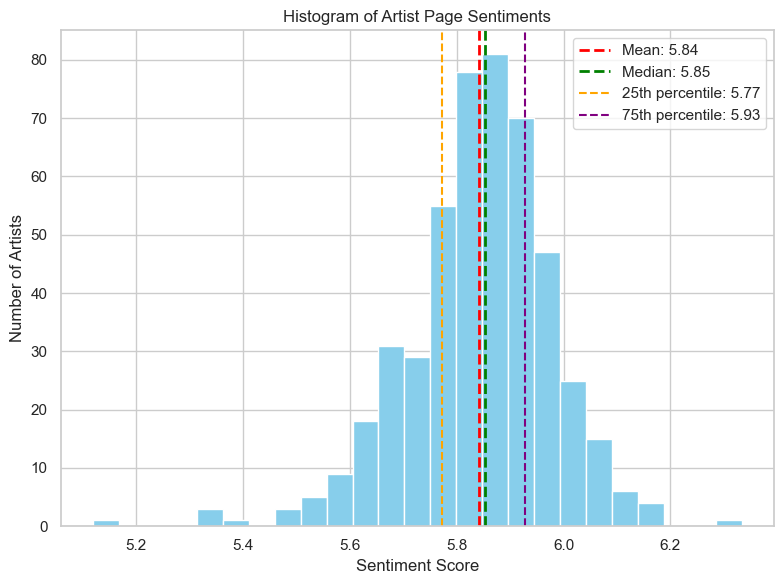

In [47]:
# Plot histogram 
sns.set(style="whitegrid")
plt.figure(figsize=(8,6))
plt.hist(sentiments_array, bins=25, color='skyblue')

# Lines for stats
plt.axvline(average_sentiment, color='red', linestyle='--', linewidth=2, label=f'Mean: {average_sentiment:.2f}')
plt.axvline(median_sentiment, color='green', linestyle='--', linewidth=2, label=f'Median: {median_sentiment:.2f}')
plt.axvline(percentile_25, color='orange', linestyle='--', linewidth=1.5, label=f'25th percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='purple', linestyle='--', linewidth=1.5, label=f'75th percentile: {percentile_75:.2f}')

plt.xlabel('Sentiment Score')
plt.ylabel('Number of Artists')
plt.title('Histogram of Artist Page Sentiments')
plt.legend()
plt.tight_layout()
plt.show()


In [48]:
# Get top 3 happiest artists
top_happy = sorted(G_und.nodes(data=True), key=lambda x: x[1]["sentiment"], reverse=True)[:3]
print("Top 3 Happiest Artists:")
for i, (name, data) in enumerate(top_happy, 1):
    print(f"{i}. {name} - Sentiment: {data['sentiment']:.2f}")

print("-----------------")

# Get top 3 saddest artists
top_sad = sorted(G_und.nodes(data=True), key=lambda x: x[1]["sentiment"])[:3]
print("Top 3 Saddest Artists:")
for i, (name, data) in enumerate(top_sad, 1):
    print(f"{i}. {name} - Sentiment: {data['sentiment']:.2f}")

Top 3 Happiest Artists:
1. fun (band) - Sentiment: 6.33
2. boys like girls - Sentiment: 6.18
3. the cars - Sentiment: 6.18
-----------------
Top 3 Saddest Artists:
1. five finger death punch - Sentiment: 5.12
2. rob zombie - Sentiment: 5.33
3. highly suspect - Sentiment: 5.33


## 3. Discuss the sentiment of the communities. 

The Louvain communities from part 2 will be used.

In [49]:
# Building the Louvain partition using NetworkX's built-in function
louvain_communities = nx.community.louvain_communities(G_und)
print(f"Total communities formed using Louvain method: {len(louvain_communities)}\n")

Total communities formed using Louvain method: 4



In [50]:
community_sentiments = {}

for i, community in enumerate(louvain_communities):
    subG = G_und.subgraph(community)

    # top 3 connected nodes
    degrees = dict(subG.degree())
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:3]
    label = ", ".join(top_nodes)

    sentiments = [G_und.nodes[node]['sentiment'] for node in subG.nodes]
    avg_sentiment = np.mean(sentiments)
    community_sentiments[label] = avg_sentiment

    print(f"{label}: avg sentiment = {avg_sentiment:.3f}")

metallica, black sabbath, led zeppelin: avg sentiment = 5.806
the beatles, bob dylan, the rolling stones: avg sentiment = 5.851
breaking benjamin, shinedown, daughtry (band): avg sentiment = 5.826
u2, david bowie, green day: avg sentiment = 5.872
